In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Overview

Read in and explore dataset:
https://www.kaggle.com/datasets/sumitm004/arxiv-scientific-research-papers-dataset

To review:

## Data Cleaning
- [X] Data structure (columns, data types, missing values)- correct as needed
- [X] Identify and handle duplicates
- [X] Generate derived features as needed and characterize

## Data Exploration
- [X] Look for class imbalance in target variable
- [X] Data distribution (histograms, box plots)
- [X] Identify temporal coverage (date ranges)
- [X] Identify statistical relationships between features


# Functions

In [2]:
def create_col_info_df(df):
    """
        Take a dataframe and create a new dataframe containing column information. 
    """
    missing_values=df.isnull().sum()
    pct_missing = (missing_values/len(df)) * 100
    datatypes = df.dtypes
    unique_values = df.nunique()

    col_info_df = pd.DataFrame({
        "Column name": df.columns,
        "Number of Missing Values": missing_values,
        "Percent Missing Values": pct_missing,
        "Datatype": datatypes,
        "Number of Unique Values": unique_values
    })
    # reset the index
    col_info_df = col_info_df.reset_index(drop=True)
    return (col_info_df)

In [66]:
#ANOVA: Check if numerical features vary significantly across categories
def anova_analysis(df, num_col, cat_col):
    categories = df[cat_col].unique()
    data_by_category = [df[df[cat_col] == cat][num_col].dropna() for cat in categories]
    f_val, p_val = stats.f_oneway(*[group for group in data_by_category if len(group) > 0])
    return f_val, p_val

In [67]:
# Chi-Square: Association between categorical variables
# Example: Check relationship between publication year and category (using top categories)
def chi_square_test(df, cat1, cat2):
    contingency_table = pd.crosstab(df[cat1], df[cat2])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return chi2, p, contingency_table

In [76]:
# Mutual Information: Measures dependence between variables
# For categorical target and mixed feature types
def calculate_mutual_info_simple(df, target, features):
    # Drop rows with missing values
    complete_df = df.dropna(subset=[target] + features)
    
    # Convert target to numeric codes
    y = complete_df[target].astype('category').cat.codes.values
    
    # Calculate mutual information for each feature individually
    mi_scores = []
    for feature in features:
        # Handle categorical features
        if complete_df[feature].dtype == 'object' or complete_df[feature].dtype.name == 'category':
            # One-hot encode categorical feature
            feature_encoded = pd.get_dummies(complete_df[feature]).values
            if feature_encoded.shape[1] > 0:
                # Calculate MI for each category and take max
                feature_mi = mutual_info_regression(feature_encoded, y)
                mi_scores.append(feature_mi.max())
            else:
                mi_scores.append(0)
        else:
            # For numerical features
            X = complete_df[feature].values.reshape(-1, 1)
            mi_scores.append(mutual_info_regression(X, y)[0])
    
    return pd.Series(mi_scores, index=features)

# Data Cleaning

In [3]:
df = pd.read_csv('../data/raw/arXiv_scientific_dataset.csv')
display(df.head())

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187


In [4]:
col_inf_df=create_col_info_df(df)
display(col_inf_df)

,Column name,Number of Missing Values,Percent Missing Values,Datatype,Number of Unique Values
0,id,0,0.0,object,136238
1,title,0,0.0,object,136154
2,category,0,0.0,object,138
3,category_code,0,0.0,object,139
4,published_date,0,0.0,object,7259
5,updated_date,0,0.0,object,7196
6,authors,0,0.0,object,125548
7,first_author,0,0.0,object,77742
8,summary,0,0.0,object,136193
9,summary_word_count,0,0.0,int64,346


# Column information
* There are 10 columns.
* There is no missing data!
* Interestingly, there are 138 categories, and 139 catagories codes- we should explore this discrepancy.
* I would have expected the 'id', 'title' and 'summary' columns to have the same number of unique values, but they do not. 
* Date columns need to be converted to datetime format.
* May be useful to create an 'author_count' column and 'title_word_count' column.

In [12]:
# update date columns to date types
# Convert to datetime and normalize to date only (drop time component)
# Convert to datetime with explicit format and normalize to date only
try:
    # Try with explicit format first
    df['published_date'] = pd.to_datetime(df['published_date'], format='%Y-%m-%d %H:%M:%S').dt.normalize()
    df['updated_date'] = pd.to_datetime(df['updated_date'], format='%Y-%m-%d %H:%M:%S').dt.normalize()
except ValueError:
    # If that fails, try without specifying format but still normalize
    print("Warning: Couldn't parse dates with specified format, falling back to automatic detection.")
    df['published_date'] = pd.to_datetime(df['published_date']).dt.normalize()
    df['updated_date'] = pd.to_datetime(df['updated_date']).dt.normalize()
print(df['published_date'].dtype)
print(df['updated_date'].dtype)

datetime64[ns]
datetime64[ns]


In [13]:
# Find all duplicate rows
duplicate_rows = df[df.duplicated()]

# Count how many duplicate rows exist
num_duplicates = len(duplicate_rows)
print(f"Number of duplicate rows: {num_duplicates}")

# You can also count duplicates including the first occurrence
all_duplicates = df[df.duplicated(keep=False)]
num_all_duplicates = len(all_duplicates)
print(f"Number of rows that appear more than once: {num_all_duplicates}")

# View the duplicates
print(duplicate_rows.head())

Number of duplicate rows: 0
Number of rows that appear more than once: 0
Empty DataFrame
Columns: [id, title, category, category_code, published_date, updated_date, authors, first_author, summary, summary_word_count]
Index: []


There are no full duplicate rows, but there are some duplicate values in the 'title' and 'summary' columns that are worth exploring. 

In [14]:
# Create a DataFrame that groups by category and counts distinct category_codes
category_mapping = df.groupby('category')['category_code'].nunique().reset_index()

# Find categories that map to more than one category_code
multiple_mappings = category_mapping[category_mapping['category_code'] > 1]

print(f"Categories with multiple category codes: {len(multiple_mappings)}")
print(multiple_mappings)

# For the categories with multiple mappings, show the actual combinations
if len(multiple_mappings) > 0:
    for category in multiple_mappings['category']:
        print(f"\nCategory: {category}")
        print(df[df['category'] == category][['category', 'category_code']].drop_duplicates())


Categories with multiple category codes: 1
              category  category_code
98  Numerical Analysis              2

Category: Numerical Analysis
                 category category_code
39965  Numerical Analysis         cs.NA
40889  Numerical Analysis       math.NA


In [15]:
# Count rows where category_code is 'cs.NA'
cs_na_count = df[df['category_code'] == 'cs.NA'].shape[0]
print(f"Number of rows where category_code == 'cs.NA': {cs_na_count}")

# Count rows where category_code is 'math.NA'
math_na_count = df[df['category_code'] == 'math.NA'].shape[0]
print(f"Number of rows where category_code == 'math.NA': {math_na_count}")

# You can also check what categories these map to
if cs_na_count > 0:
    print("\nCategories for 'cs.NA':")
    print(df[df['category_code'] == 'cs.NA']['category'].value_counts())

if math_na_count > 0:
    print("\nCategories for 'math.NA':")
    print(df[df['category_code'] == 'math.NA']['category'].value_counts())

Number of rows where category_code == 'cs.NA': 25
Number of rows where category_code == 'math.NA': 56

Categories for 'cs.NA':
category
Numerical Analysis    25
Name: count, dtype: int64

Categories for 'math.NA':
category
Numerical Analysis    56
Name: count, dtype: int64


In [16]:
# Filter for rows where category is 'Numerical Analysis'
na_rows = df[df['category'] == 'Numerical Analysis']
display(na_rows)

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
39965,abs-1312.6872v1,Matrix recovery using Split Bregman,Numerical Analysis,cs.NA,2013-12-17,2013-12-17,"['Anupriya Gogna', 'Ankita Shukla', 'Angshul M...",'Anupriya Gogna',In this paper we address the problem of recove...,157
39971,abs-1401.0159v1,Speeding-Up Convergence via Sequential Subspac...,Numerical Analysis,cs.NA,2013-12-31,2013-12-31,['Michael Zibulevsky'],'Michael Zibulevsky',This is an overview paper written in style of ...,161
39985,abs-1407.1399v1,Generalized Higher-Order Tensor Decomposition ...,Numerical Analysis,cs.NA,2014-07-05,2014-07-05,"['Fanhua Shang', 'Yuanyuan Liu', 'James Cheng']",'Fanhua Shang',Higher-order tensors are becoming prevalent in...,166
40351,abs-1601.07721v1,Distributed Low Rank Approximation of Implicit...,Numerical Analysis,cs.NA,2016-01-28,2016-01-28,"['David P. Woodruff', 'Peilin Zhong']",'David P. Woodruff',We study distributed low rank approximation in...,212
40889,abs-1707.09428v1,A unified method for super-resolution recovery...,Numerical Analysis,math.NA,2017-07-26,2017-07-26,"['Charles K. Chui', 'Hrushikesh N. Mhaskar']",'Charles K. Chui',"In this paper, motivated by diffraction of tra...",151
...,...,...,...,...,...,...,...,...,...,...
111897,abs-2309.05947v3,Tumoral Angiogenic Optimizer: A new bio-inspir...,Numerical Analysis,math.NA,2023-09-12,2023-09-20,"['Hernández Rodríguez', 'Matías Ezequiel']",'Hernández Rodríguez',"In this article, we propose a new metaheuristi...",185
112591,abs-1605.09232v3,Tradeoffs between Convergence Speed and Recons...,Numerical Analysis,cs.NA,2016-05-30,2018-02-15,"['Raja Giryes', 'Yonina C. Eldar', 'Alex M. Br...",'Raja Giryes',Solving inverse problems with iterative algori...,164
112632,abs-1706.04702v1,Deep learning-based numerical methods for high...,Numerical Analysis,math.NA,2017-06-15,2017-06-15,"['Weinan E', 'Jiequn Han', 'Arnulf Jentzen']",'Weinan E',We propose a new algorithm for solving parabol...,118
112975,abs-2408.14057v1,Revisiting time-variant complex conjugate matr...,Numerical Analysis,math.NA,2024-08-26,2024-08-26,"['Jiakuang He', 'Dongqing Wu']",'Jiakuang He',Large-scale linear equations and high dimensio...,134


The 'Numerical Analysis' category is the only one that seems to map to two codes. And, this happens more than once. It is unclear if this is a data entry error or if the category is actually meant to be two codes. I will leave this for now, but it may be worth exploring more later.


In [17]:
# Investigate why the 'title' unique values do not match the id unique values
title_cts= df['title'].value_counts()
non_unique_titles = title_cts[title_cts > 1]
print(f"There are {len(non_unique_titles)} duplicate titles")
print(non_unique_titles)

There are 84 duplicate titles
title
Fairness in Reinforcement Learning                                                                             2
SCREEN: Learning a Flat Syntactic and Semantic Spoken Language Analysis\n  Using Artificial Neural Networks    2
Bridging the Gap Between Target Networks and Functional Regularization                                         2
Conditional Plausibility Measures and Bayesian Networks                                                        2
Interpretable Two-level Boolean Rule Learning for Classification                                               2
                                                                                                              ..
Standards for Language Resources                                                                               2
Fair Active Learning                                                                                           2
Hypertree Decompositions Revisited for PGMs                 

In [18]:
display(df[df['title'].isin(non_unique_titles.index.tolist())].sort_values(by='title'))

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
130124,cmp-lg-9407014v1,Abstract Machine for Typed Feature Structures,Computation and Language (Legacy category),cmp-lg,1994-07-17,1994-07-17,"['Shuly Wintner', 'Nissim Francez']",'Shuly Wintner',This paper describes a first step towards the ...,107
130324,cmp-lg-9504009v1,Abstract Machine for Typed Feature Structures,Computation and Language (Legacy category),cmp-lg,1995-04-13,1995-04-13,"['Shuly Wintner', 'Nissim Francez']",'Shuly Wintner',This paper describes an abstract machine for l...,116
2472,abs-1408.2056v1,Active Sensing as Bayes-Optimal Sequential Dec...,Artificial Intelligence,cs.AI,2014-08-09,2014-08-09,"['Sheeraz Ahmad', 'Angela Yu']",'Sheeraz Ahmad',Sensory inference under conditions of uncertai...,177
10523,abs-1305.6650v1,Active Sensing as Bayes-Optimal Sequential Dec...,Artificial Intelligence,cs.AI,2013-05-28,2013-05-28,"['Sheeraz Ahmad', 'Angela J. Yu']",'Sheeraz Ahmad',Sensory inference under conditions of uncertai...,177
2467,abs-1408.2034v1,Approximate inference on planar graphs using L...,Artificial Intelligence,cs.AI,2014-08-09,2014-08-09,"['Vicenc Gomez', 'Hilbert Kappen', 'Michael Ch...",'Vicenc Gomez',We introduce novel results for approximate inf...,153
...,...,...,...,...,...,...,...,...,...,...
2447,abs-1407.7188v1,When Ignorance is Bliss,Artificial Intelligence,cs.AI,2014-07-27,2014-07-27,"['Peter D. Grunwald', 'Joseph Y. Halpern']",'Peter D. Grunwald',It is commonly-accepted wisdom that more infor...,120
17549,abs-2206.07940v4,When Rigidity Hurts: Soft Consistency Regulari...,Machine Learning,cs.LG,2022-06-16,2023-10-19,"['Harshavardhan Kamarthi', 'Lingkai Kong', 'Al...",'Harshavardhan Kamarthi',Probabilistic hierarchical time-series forecas...,211
21739,abs-2310.11569v2,When Rigidity Hurts: Soft Consistency Regulari...,Machine Learning,cs.LG,2023-10-17,2023-10-19,"['Harshavardhan Kamarthi', 'Lingkai Kong', 'Al...",'Harshavardhan Kamarthi',Probabilistic hierarchical time-series forecas...,211
2463,abs-1408.1692v1,When do Numbers Really Matter?,Artificial Intelligence,cs.AI,2014-08-07,2014-08-07,"['Hei Chan', 'Adnan Darwiche']",'Hei Chan',Common wisdom has it that small distinctions i...,140


Some of these seem to be true duplicate papers, even though some of the extra columns are different. There are only 84 duplicate titles. 

There is at least one that is not a duplicate (same title, different authors), but many of the others have similar author lists. 

To Start:
* Remove the older row where the title and first_auther are the same. I know this will miss some things (Joris M. Mooij vs. Joris Mooij), but it is a start.
* Review the list again to see if there are other candidates for removal. 

In [19]:
# Define which columns determine a "duplicate" paper
duplicate_columns = ['title', 'first_author']

# Sort the dataframe by updated_date (oldest first)
# This ensures when we drop duplicates, we'll keep the latest one (last occurrence)
df_sorted = df.sort_values('updated_date')

# Drop duplicates, keeping the last occurrence (which will be the most recent)
df_deduplicated = df_sorted.drop_duplicates(subset=duplicate_columns, keep='last').copy()

# Print results
print(f"Original dataframe: {len(df)} rows")
print(f"After removing older duplicates: {len(df_deduplicated)} rows")
print(f"Removed {len(df) - len(df_deduplicated)} rows")

Original dataframe: 136238 rows
After removing older duplicates: 136175 rows
Removed 63 rows


In [20]:
#recheck duplicates
title_cts= df_deduplicated['title'].value_counts()
non_unique_titles = title_cts[title_cts > 1]
print(f"There are {len(non_unique_titles)} duplicate titles")
print(non_unique_titles)

There are 21 duplicate titles
title
Bayesian Neural Networks                                                                                       2
Bridging the Gap Between Target Networks and Functional Regularization                                         2
Character-based Neural Machine Translation                                                                     2
Bandit Algorithms for Tree Search                                                                              2
Optimally-Weighted Herding is Bayesian Quadrature                                                              2
Bayesian Multitask Learning with Latent Hierarchies                                                            2
Fairness in Reinforcement Learning                                                                             2
Convolutional Conditional Neural Processes                                                                     2
When do Numbers Really Matter?                              

In [21]:
display(df_deduplicated[df_deduplicated['title'].isin(non_unique_titles.index.tolist())].sort_values(by='title'))

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
2467,abs-1408.2034v1,Approximate inference on planar graphs using L...,Artificial Intelligence,cs.AI,2014-08-09,2014-08-09,"['Vicenc Gomez', 'Hilbert Kappen', 'Michael Ch...",'Vicenc Gomez',We introduce novel results for approximate inf...,153
464,abs-0901.0786v3,Approximate inference on planar graphs using L...,Artificial Intelligence,cs.AI,2009-01-07,2009-05-25,"['V. Gómez', 'H. J. Kappen', 'M. Chertkov']",'V. Gómez',We introduce novel results for approximate inf...,177
2465,abs-1408.2028v1,Bandit Algorithms for Tree Search,Artificial Intelligence,cs.AI,2014-08-09,2014-08-09,"['Pierre-Arnuad Coquelin', 'Remi Munos']",'Pierre-Arnuad Coquelin',Bandit based methods for tree search have rece...,225
24601,cs-0703062v1,Bandit Algorithms for Tree Search,Machine Learning,cs.LG,2007-03-13,2007-03-13,"['Pierre-Arnaud Coquelin', 'Rémi Munos']",'Pierre-Arnaud Coquelin',Bandit based methods for tree search have rece...,223
24680,abs-0907.0783v1,Bayesian Multitask Learning with Latent Hierar...,Machine Learning,cs.LG,2009-07-04,2009-07-04,['Hal Daumé III'],'Hal Daumé III',We learn multiple hypotheses for related tasks...,60
40034,abs-1408.2032v1,Bayesian Multitask Learning with Latent Hierar...,Machine Learning,cs.LG,2014-08-09,2014-08-09,['Hal Daume III'],'Hal Daume III',We learn multiple hypotheses for related tasks...,60
98307,abs-2006.01490v2,Bayesian Neural Networks,Machine Learning (Statistics),stat.ML,2020-06-02,2020-11-06,"['Tom Charnock', 'Laurence Perreault-Levasseur...",'Tom Charnock',"In recent times, neural networks have become a...",199
98124,abs-1801.07710v2,Bayesian Neural Networks,Machine Learning,cs.LG,2018-01-23,2018-01-30,"['Vikram Mullachery', 'Aniruddh Khera', 'Amir ...",'Vikram Mullachery',This paper describes and discusses Bayesian Ne...,210
88417,abs-2007.15553v1,Bilevel Continual Learning,Machine Learning,cs.LG,2020-07-30,2020-07-30,"['Quang Pham', 'Doyen Sahoo', 'Chenghao Liu', ...",'Quang Pham',Continual learning aims to learn continuously ...,158
28106,abs-2011.01168v1,Bilevel Continual Learning,Machine Learning,cs.LG,2020-11-02,2020-11-02,"['Ammar Shaker', 'Francesco Alesiani', 'Shujia...",'Ammar Shaker',Continual learning (CL) studies the problem of...,208


There are still some duplicates, but in some cases, there are distinct pappers with the same title. 

I could potentially write some code to better match author names, but this would be a lot of work, and this number is small enough that I can manually create a list of indexes to remove. 

In [22]:
#idexes to remove- checked twice.
idx_to_remove=[464, 24601, 24680, 88894, 107047, 67, 84, 54132, 10504, 48, 76587, 130176, 48292, 75, 722]
df_deduplicated.drop(index=idx_to_remove, inplace=True)

In [23]:
#check that there are the expected number duplicate titles
title_cts= df_deduplicated['title'].value_counts()
non_unique_titles = title_cts[title_cts > 1]
print(f"There are {len(non_unique_titles)} duplicate titles")
print(non_unique_titles)

There are 6 duplicate titles
title
Character-based Neural Machine Translation    2
Dynamic Belief Fusion for Object Detection    2
Bayesian Neural Networks                      2
Convolutional Conditional Neural Processes    2
Fairness in Reinforcement Learning            2
Bilevel Continual Learning                    2
Name: count, dtype: int64


In [ ]:
#clean up
df=df_deduplicated.copy()
del(df_deduplicated)
del(df_sorted)
display(df.head())

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,1993-08-01,1993-08-01,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,1993-08-01,1993-08-01,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,1993-09-01,1993-09-01,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,1993-11-01,1993-11-01,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,1993-11-01,1993-11-01,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187


In [25]:
df['author_count']=df['authors'].apply(lambda x: len(x.split(',')))
df['title_count']=df['title'].apply(lambda x: len(str(x).split()))
display(df.head())

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count,author_count,title_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,1993-08-01,1993-08-01,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79,1,2
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,1993-08-01,1993-08-01,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119,1,12
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,1993-09-01,1993-09-01,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167,2,7
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,1993-11-01,1993-11-01,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174,3,8
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,1993-11-01,1993-11-01,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187,2,8


In [26]:
df.describe()

,published_date,updated_date,summary_word_count,author_count,title_count
count,136160,136160,136160.000000,136160.000000,136160.000000
mean,2019-10-25 18:43:38.143360512,2020-01-31 08:54:22.420681728,162.399457,3.977894,9.067854
min,1993-08-01 00:00:00,1993-08-01 00:00:00,1.000000,1.000000,1.000000
25%,2018-03-03 00:00:00,2018-05-23 00:00:00,128.000000,2.000000,7.000000
50%,2020-06-30 00:00:00,2020-11-09 00:00:00,160.000000,4.000000,9.000000
75%,2022-09-20 00:00:00,2022-12-10 00:00:00,195.000000,5.000000,11.000000
max,2025-01-30 00:00:00,2025-01-30 00:00:00,552.000000,1137.000000,36.000000
std,NaN,NaN,49.372563,4.233442,3.168269


In [27]:
#save cleaned dataframe
df.to_csv('../data/processed/arXiv_scientific_dataset_cleaned.csv', index=False)


# Data cleaning conclusion

Overall the data was not in horrible shape. There were no missing values. The date columns needed to be converted to datetime format. There were some duplicate rows, but they were not too difficult to clean up. There may be more cleaning to do after the exploratory data analysis, but I will leave that for now.

# Exploratory Analysis

## Defining and characterizing the target variable

For this analysis, you could use either the 'category' or the 'category_code' column. These are largely equivalent. The category column is easier to read, but the category_code is shorter. The other advantage of using the category_code is the duplicate we see with Numerical Analysis. It is unclear to me that there is much a  distinction between math.NA and cs.NA, but if there is we may be able to capture it with the category_code.

Let's output a mapping of these two columns, but use the category_code for the actual analysis. 

In [28]:
category_mapping = df[['category_code', 'category']].drop_duplicates().sort_values(by='category').reset_index().drop(columns='index')
display(category_mapping)

,category_code,category
0,physics.acc-ph,Accelerator Physics
1,nlin.AO,Adaptation and Self-Organizing Systems
2,math.AG,Algebraic Geometry
3,math.AT,Algebraic Topology
4,math.AP,Analysis of PDEs
...,...,...
134,cs.SC,Symbolic Computation
135,cs.SY,Systems and Control
136,eess.SY,Systems and Control (Electrical Engineering an...
137,q-bio.TO,Tissues and Organs


In [29]:
category_mapping.to_csv('../data/processed/arXiv_category_mapping.csv', index=False)

In [30]:
# This is a multiclass classification problem. Let's look at some basic stats. 
# Get the distribution of category_code values
category_counts = df['category_code'].value_counts()

# Look at basic statistics
print(f"Total classes: {len(category_counts)}")
print(f"Most common class: {category_counts.index[0]} with {category_counts.iloc[0]} instances")
print(f"Least common class: {category_counts.index[-1]} with {category_counts.iloc[-1]} instances")
print(f"Mean instances per class: {category_counts.mean():.2f}")
print(f"Median instances per class: {category_counts.median():.2f}")

# Calculate imbalance metrics
imbalance_ratio = category_counts.iloc[0] / category_counts.iloc[-1]
print(f"Imbalance ratio (most common / least common): {imbalance_ratio:.2f}")

# Check how many classes have very few samples
rare_threshold = 100  # Adjust based on your dataset size
rare_classes = category_counts[category_counts < rare_threshold]
print(f"Classes with fewer than {rare_threshold} samples: {len(rare_classes)} ({len(rare_classes)/len(category_counts):.1%})")

Total classes: 139
Most common class: cs.LG with 39967 instances
Least common class: math.CV with 1 instances
Mean instances per class: 979.57
Median instances per class: 25.00
Imbalance ratio (most common / least common): 39967.00
Classes with fewer than 100 samples: 103 (74.1%)


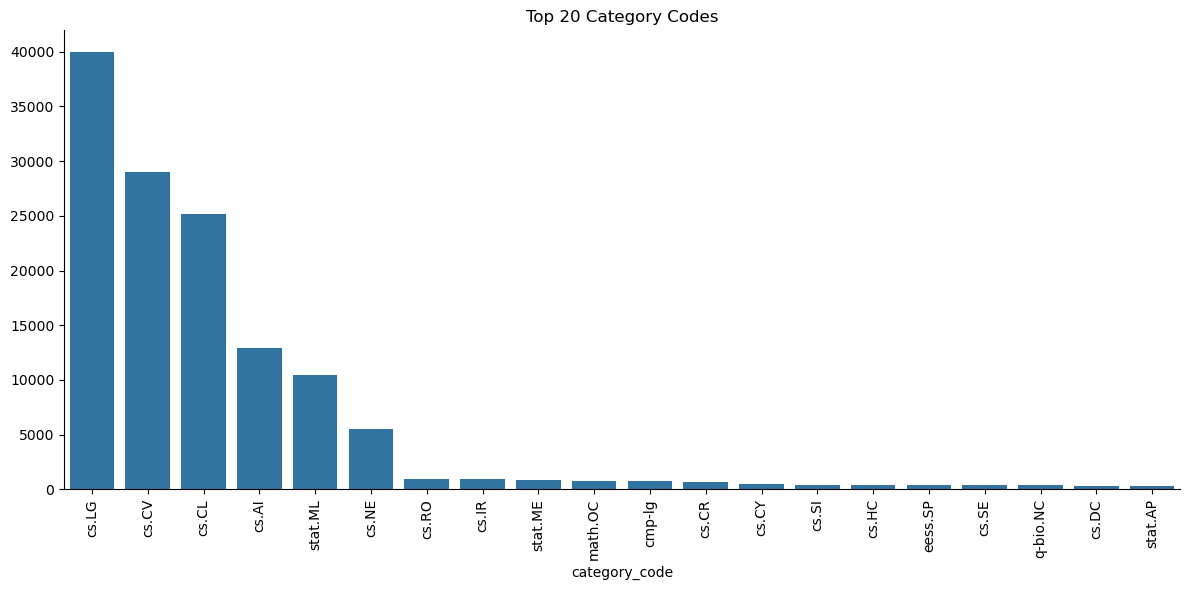

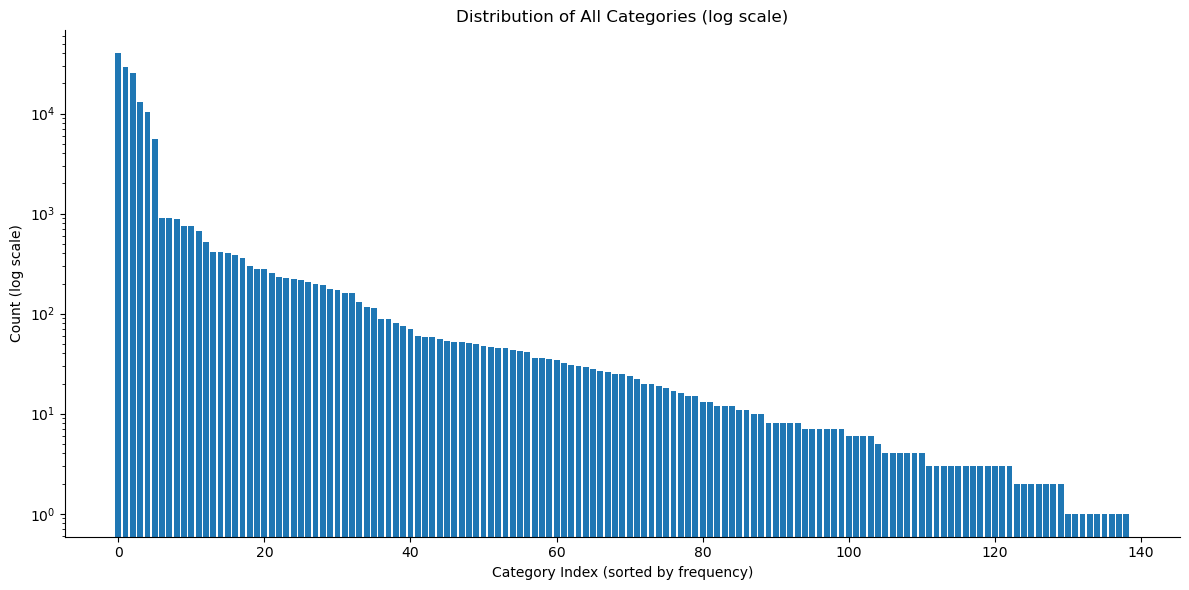

In [31]:
# Plot the distribution of the top 20 classes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
top_20 = category_counts.head(20)
sns.barplot(x=top_20.index, y=top_20.values)
plt.xticks(rotation=90)
plt.title('Top 20 Category Codes')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

# Plot the distribution on a log scale to better see the imbalance
plt.figure(figsize=(12, 6))
plt.bar(range(len(category_counts)), category_counts.values)
plt.yscale('log')
plt.xlabel('Category Index (sorted by frequency)')
plt.ylabel('Count (log scale)')
plt.title('Distribution of All Categories (log scale)')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [32]:
# Calculate deciles
deciles = np.percentile(category_counts, np.arange(0, 101, 10))
print("Deciles of category counts:")
for i, value in enumerate(deciles):
    print(f"{i*10}th percentile: {value:.1f}")

# Look at what percentage of the data is in the top categories
total_samples = len(df)
top_6_counts = category_counts.head(6).sum()
top_6_percentage = (top_6_counts / total_samples) * 100

# Show the top 6 categories
print("\nTop 6 categories:")
for i, (cat, count) in enumerate(category_counts.head(6).items(), 1):
    print(f"{i}. {cat}: {count} samples ({count/total_samples:.1%} of total)")

print(f"\nThe top 6 categories contain {top_6_percentage:.1f}% of all data")

# Calculate cumulative percentage of data covered as we add categories
cumulative = pd.DataFrame({
    'category': category_counts.index,
    'count': category_counts.values,
    'percentage': category_counts.values / total_samples * 100
})
cumulative['cumulative_percentage'] = cumulative['percentage'].cumsum()

# How many categories to cover 80%, 90%, 95% of the data?
for threshold in [80, 90, 95, 99]:
    cats_needed = cumulative[cumulative['cumulative_percentage'] <= threshold].shape[0]
    if cats_needed < len(cumulative):
        print(f"Need {cats_needed+1} categories to cover {threshold}% of the data")

Deciles of category counts:
0th percentile: 1.0
10th percentile: 2.0
20th percentile: 3.6
30th percentile: 7.0
40th percentile: 12.0
50th percentile: 25.0
60th percentile: 41.8
70th percentile: 59.6
80th percentile: 194.6
90th percentile: 412.2
100th percentile: 39967.0

Top 6 categories:
1. cs.LG: 39967 samples (29.4% of total)
2. cs.CV: 29050 samples (21.3% of total)
3. cs.CL: 25198 samples (18.5% of total)
4. cs.AI: 12943 samples (9.5% of total)
5. stat.ML: 10432 samples (7.7% of total)
6. cs.NE: 5507 samples (4.0% of total)

The top 6 categories contain 90.4% of all data
Need 5 categories to cover 80% of the data
Need 6 categories to cover 90% of the data
Need 16 categories to cover 95% of the data
Need 47 categories to cover 99% of the data


# Significant class imbalance

There is significant class imbalance in the target variable. The top 6 categories make up 90% of the data. 

# Analyzing other variables


In [33]:
# Descriptive statistics for the numerical columns
num_cols = ['summary_word_count', 'author_count', 'title_count']
print("Basic statistics:")
print(df[num_cols].describe())

Basic statistics:
       summary_word_count   author_count    title_count
count       136160.000000  136160.000000  136160.000000
mean           162.399457       3.977894       9.067854
std             49.372563       4.233442       3.168269
min              1.000000       1.000000       1.000000
25%            128.000000       2.000000       7.000000
50%            160.000000       4.000000       9.000000
75%            195.000000       5.000000      11.000000
max            552.000000    1137.000000      36.000000


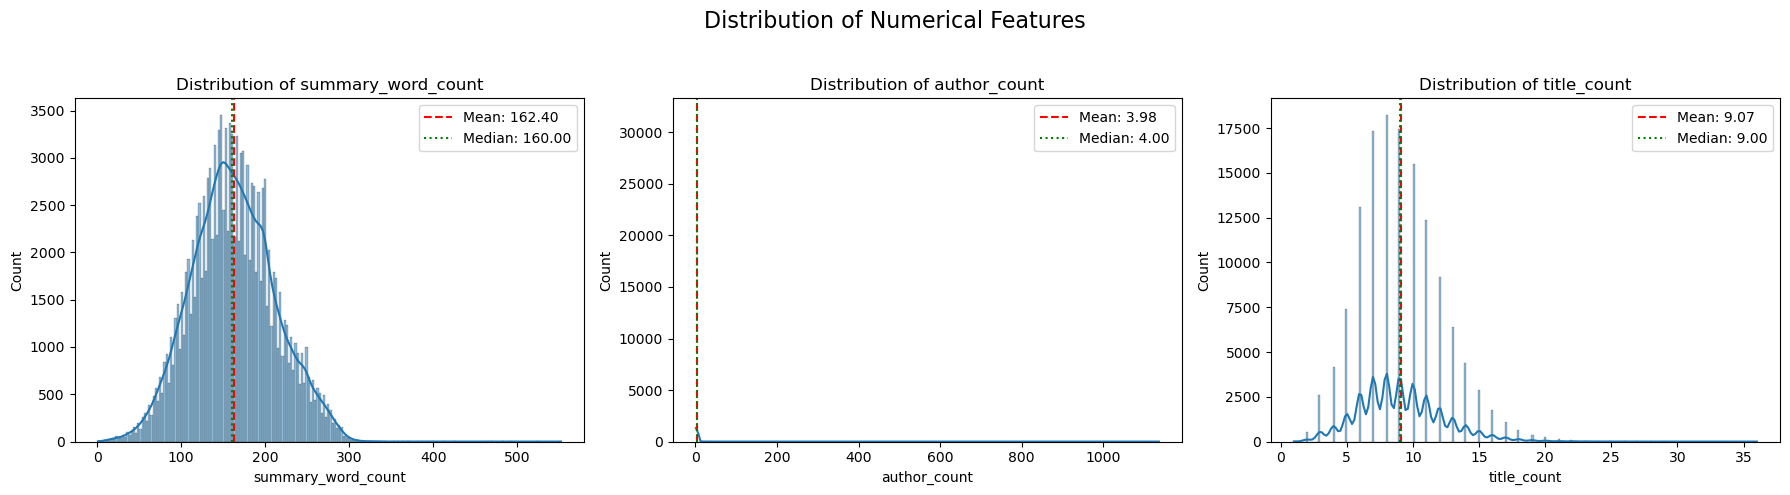

In [34]:
# Create a figure with subplots for histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Numerical Features', fontsize=16)

# Plot histograms for each numerical column
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    
    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='g', linestyle=':', label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

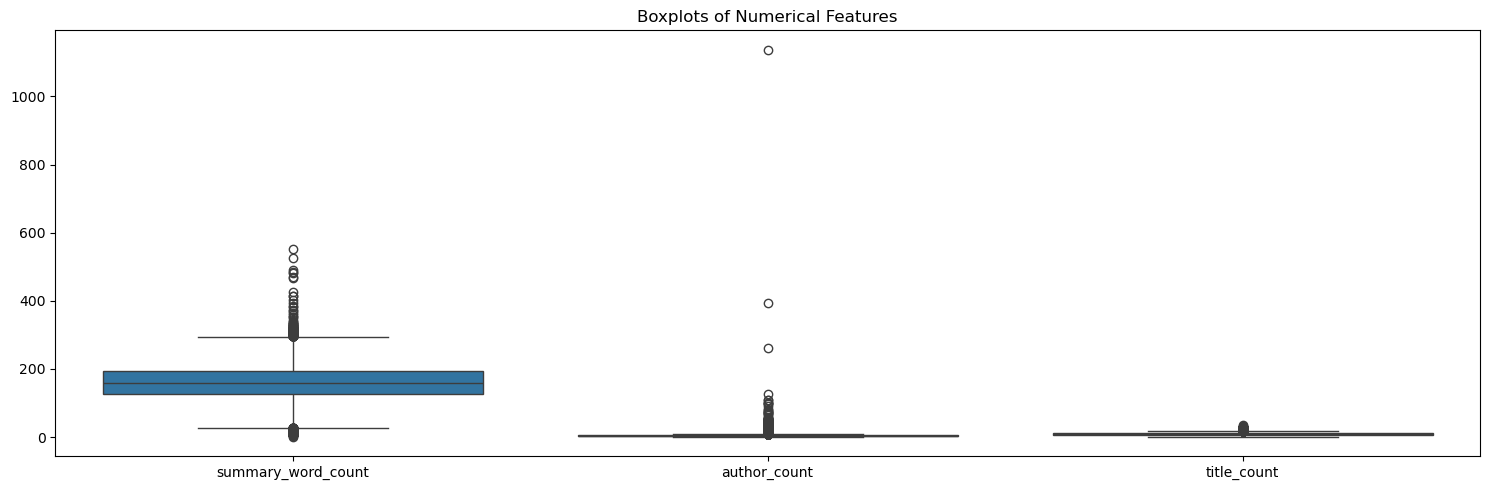

In [35]:
# Check for outliers using boxplots
plt.figure(figsize=(15, 5))
sns.boxplot(data=df[num_cols])
plt.title('Boxplots of Numerical Features')
plt.tight_layout()
plt.show()

In [36]:
# Calculate correlation matrix
corr_matrix = df[num_cols].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)


Correlation Matrix:
                    summary_word_count  author_count  title_count
summary_word_count            1.000000      0.089083     0.145415
author_count                  0.089083      1.000000     0.033199
title_count                   0.145415      0.033199     1.000000


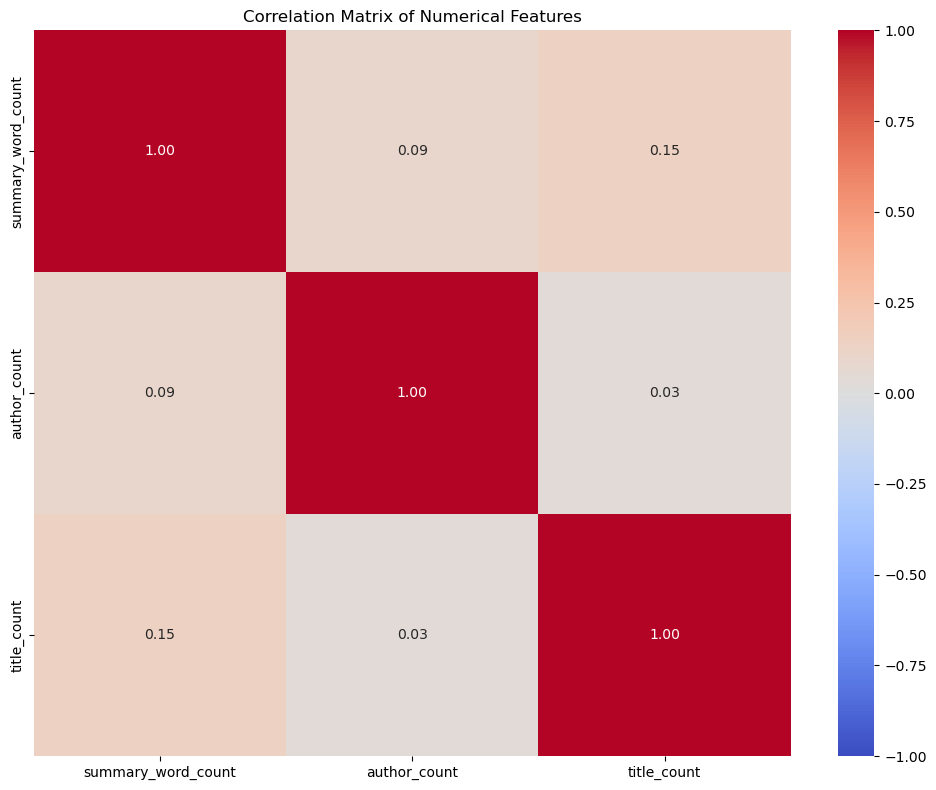

In [37]:
# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [38]:
# Check if distributions are skewed
print("\nSkewness of distributions:")
for col in num_cols:
    skew_val = stats.skew(df[col].dropna())
    print(f"{col}: {skew_val:.3f}")
    
    if abs(skew_val) > 1:
        print(f"  - Highly skewed (may need transformation)")
    elif abs(skew_val) > 0.5:
        print(f"  - Moderately skewed")
    else:
        print(f"  - Approximately symmetric")


Skewness of distributions:
summary_word_count: 0.151
  - Approximately symmetric
author_count: 150.122
  - Highly skewed (may need transformation)
title_count: 0.656
  - Moderately skewed


# Overall conclusions

* There is no correlation between the numerical variables. 
* The summary_word_count is approximately symmetric.
* The author_count is highly skwed. 
* The title count is moderately skewed. 

In [39]:
# Let's transform the two skewed features
# Start with author count- will try multiple approaches to see what works best

# Log transformation (add 1 to handle zeros)
df['author_count_log'] = np.log1p(df['author_count'])

# Square root transformation
df['author_count_sqrt'] = np.sqrt(df['author_count'])

# Box-Cox transformation (if all values are positive)
if (df['author_count'] > 0).all():
    df['author_count_boxcox'], _ = stats.boxcox(df['author_count'])

# Yeo-Johnson transformation (handles zero and negative values)
df['author_count_yeojohnson'], _ = stats.yeojohnson(df['author_count'])




In [40]:
# Now title count
# Log transformation
df['title_count_log'] = np.log1p(df['title_count'])

# Square root transformation
df['title_count_sqrt'] = np.sqrt(df['title_count'])


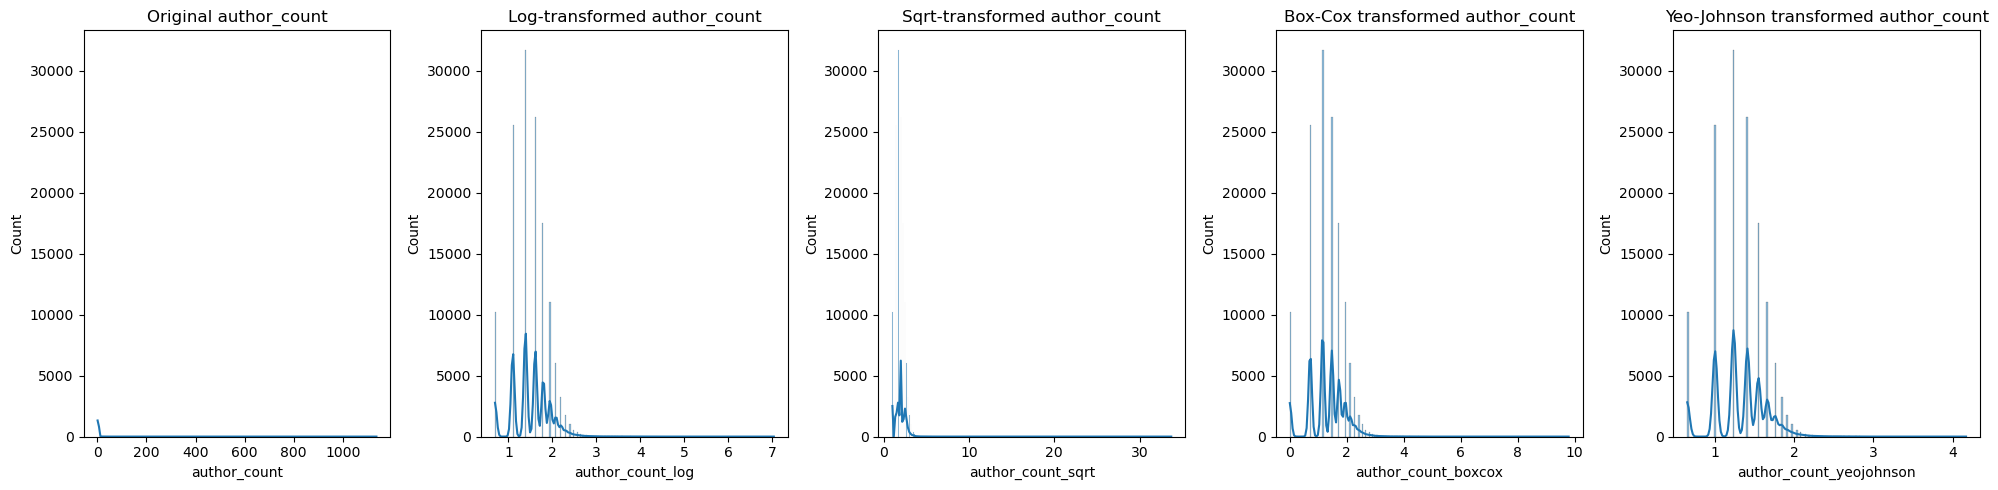

In [41]:
# Plot 1: Author count with all transformations
fig1, axes1 = plt.subplots(1, 5, figsize=(20, 5))

# Original and transformations for author_count
sns.histplot(df['author_count'], kde=True, ax=axes1[0])
axes1[0].set_title('Original author_count')

sns.histplot(df['author_count_log'], kde=True, ax=axes1[1])
axes1[1].set_title('Log-transformed author_count')

sns.histplot(df['author_count_sqrt'], kde=True, ax=axes1[2])
axes1[2].set_title('Sqrt-transformed author_count')

sns.histplot(df['author_count_boxcox'], kde=True, ax=axes1[3])
axes1[3].set_title('Box-Cox transformed author_count')

sns.histplot(df['author_count_yeojohnson'], kde=True, ax=axes1[4])
axes1[4].set_title('Yeo-Johnson transformed author_count')

plt.tight_layout()
plt.show()

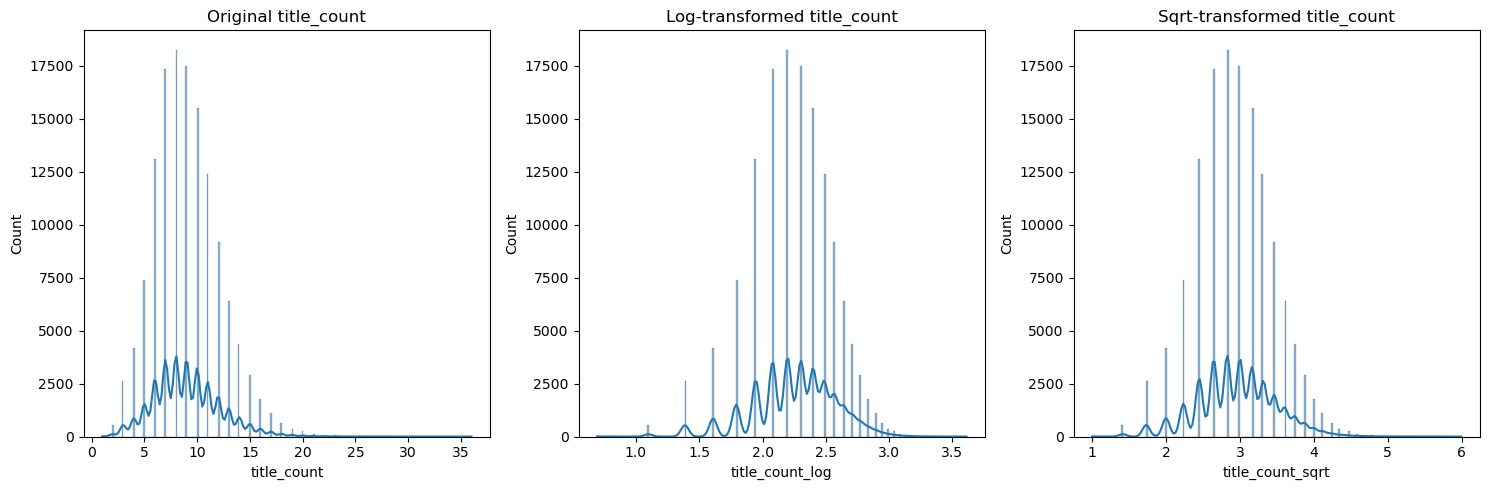

In [42]:
# Plot 2: Title count with transformations
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))

# Original and transformations for title_count
sns.histplot(df['title_count'], kde=True, ax=axes2[0])
axes2[0].set_title('Original title_count')

sns.histplot(df['title_count_log'], kde=True, ax=axes2[1])
axes2[1].set_title('Log-transformed title_count')

sns.histplot(df['title_count_sqrt'], kde=True, ax=axes2[2])
axes2[2].set_title('Sqrt-transformed title_count')

plt.tight_layout()
plt.show()

In [43]:
# Print skewness values for all transformations
print("Skewness values for author_count:")
print(f"Original: {stats.skew(df['author_count']):.3f}")
print(f"Log-transformed: {stats.skew(df['author_count_log']):.3f}")
print(f"Sqrt-transformed: {stats.skew(df['author_count_sqrt']):.3f}")
print(f"Box-Cox transformed: {stats.skew(df['author_count_boxcox']):.3f}")
print(f"Yeo-Johnson transformed: {stats.skew(df['author_count_yeojohnson']):.3f}")

print("\nSkewness values for title_count:")
print(f"Original: {stats.skew(df['title_count']):.3f}")
print(f"Log-transformed: {stats.skew(df['title_count_log']):.3f}")
print(f"Sqrt-transformed: {stats.skew(df['title_count_sqrt']):.3f}")

Skewness values for author_count:
Original: 150.122
Log-transformed: 0.276
Sqrt-transformed: 3.051
Box-Cox transformed: 0.016
Yeo-Johnson transformed: -0.012

Skewness values for title_count:
Original: 0.656
Log-transformed: -0.445
Sqrt-transformed: 0.042


Based on the skewness values, I think we will use Box-Cox for author_count and Sqrt-transformed fro title_count. 

Drop other columns for now.

In [44]:
df = df.drop(columns=['author_count_log', 'author_count_sqrt', 'author_count_yeojohnson', 'title_count_log'])
display(df.head())

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count,author_count,title_count,author_count_boxcox,title_count_sqrt
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,1993-08-01,1993-08-01,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79,1,2,0.000000,1.414214
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,1993-08-01,1993-08-01,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119,1,12,0.000000,3.464102
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,1993-09-01,1993-09-01,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167,2,7,0.715010,2.645751
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,1993-11-01,1993-11-01,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174,3,8,1.154208,2.828427
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,1993-11-01,1993-11-01,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187,2,8,0.715010,2.828427


# Look at temporal data

In [45]:
# Get the range (min and max) for both date columns
print("Date Ranges:")
print(f"published_date: {df['published_date'].min()} to {df['published_date'].max()}")
print(f"updated_date: {df['updated_date'].min()} to {df['updated_date'].max()}")

Date Ranges:
published_date: 1993-08-01 00:00:00 to 2025-01-30 00:00:00
updated_date: 1993-08-01 00:00:00 to 2025-01-30 00:00:00


In [47]:
# Get the range (min and max) for both date columns
print("Date Ranges:")
print(f"published_date: {df['published_date'].min().date()} to {df['published_date'].max().date()}")
print(f"updated_date: {df['updated_date'].min().date()} to {df['updated_date'].max().date()}")

# Create date features for different granularities
df['published_year'] = df['published_date'].dt.year
df['published_quarter'] = df['published_date'].dt.to_period('Q')
df['published_month'] = df['published_date'].dt.to_period('M')

df['updated_year'] = df['updated_date'].dt.year
df['updated_quarter'] = df['updated_date'].dt.to_period('Q')
df['updated_month'] = df['updated_date'].dt.to_period('M')


Date Ranges:
published_date: 1993-08-01 to 2025-01-30
updated_date: 1993-08-01 to 2025-01-30


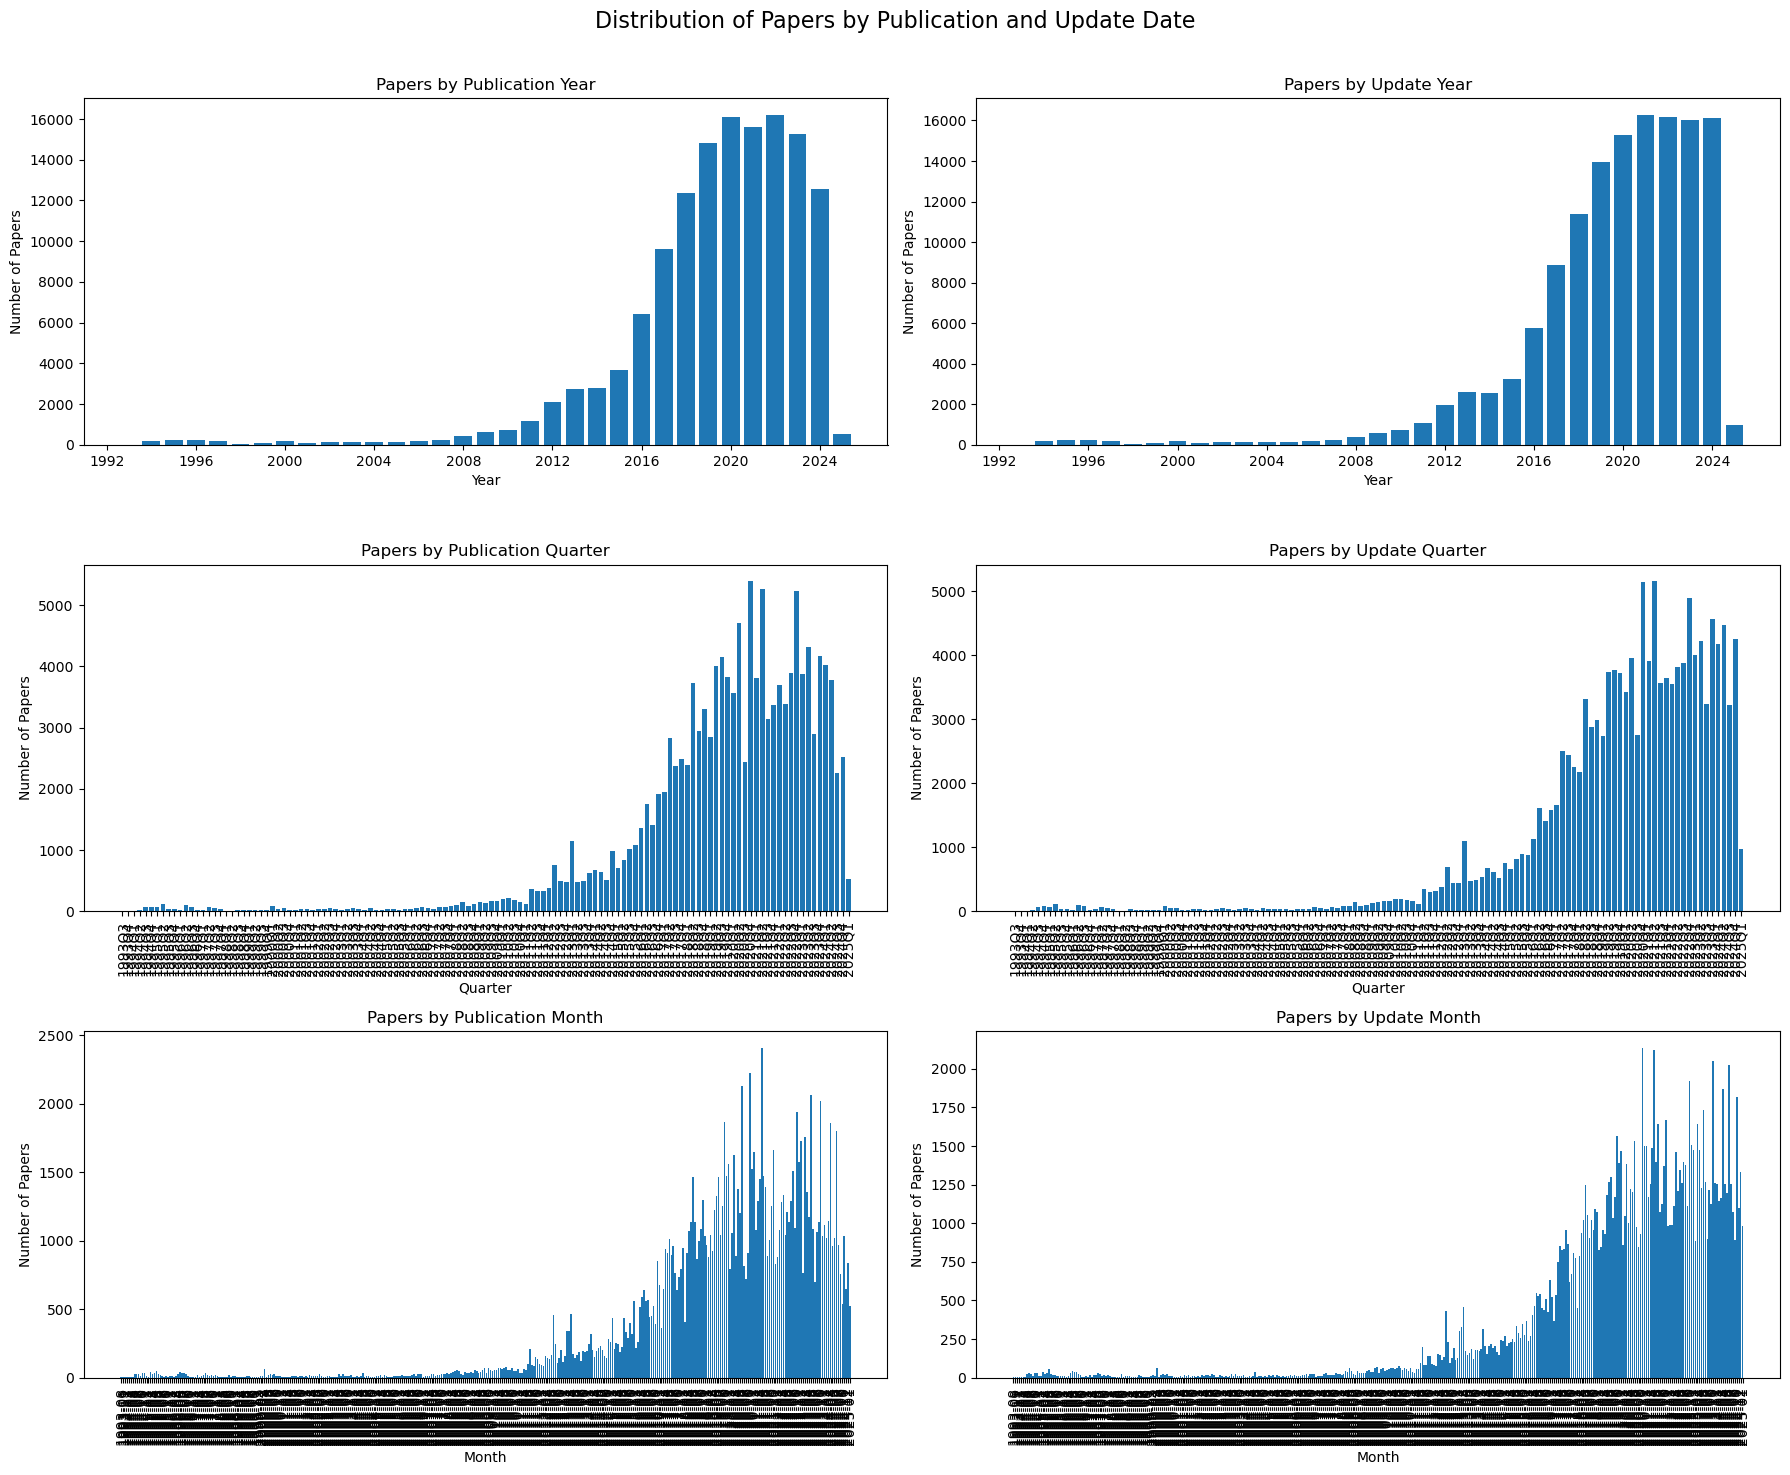

In [52]:
# Set up figure and axes for the plots
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle('Distribution of Papers by Publication and Update Date', fontsize=16)

# Yearly plots
yearly_pub = df['published_year'].value_counts().sort_index()
yearly_update = df['updated_year'].value_counts().sort_index()

axes[0, 0].bar(yearly_pub.index, yearly_pub.values)
axes[0, 0].set_title('Papers by Publication Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Papers')
axes[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

axes[0, 1].bar(yearly_update.index, yearly_update.values)
axes[0, 1].set_title('Papers by Update Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Number of Papers')
axes[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Quarterly plots
quarterly_pub = df['published_quarter'].value_counts().sort_index()
quarterly_update = df['updated_quarter'].value_counts().sort_index()

axes[1, 0].bar(quarterly_pub.index.astype(str), quarterly_pub.values)
axes[1, 0].set_title('Papers by Publication Quarter')
axes[1, 0].set_xlabel('Quarter')
axes[1, 0].set_ylabel('Number of Papers')
axes[1, 0].tick_params(axis='x', rotation=90)

axes[1, 1].bar(quarterly_update.index.astype(str), quarterly_update.values)
axes[1, 1].set_title('Papers by Update Quarter')
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Number of Papers')
axes[1, 1].tick_params(axis='x', rotation=90)

# Monthly plots
monthly_pub = df['published_month'].value_counts().sort_index()
monthly_update = df['updated_month'].value_counts().sort_index()

axes[2, 0].bar(monthly_pub.index.astype(str), monthly_pub.values)
axes[2, 0].set_title('Papers by Publication Month')
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('Number of Papers')
axes[2, 0].tick_params(axis='x', rotation=90)

axes[2, 1].bar(monthly_update.index.astype(str), monthly_update.values)
axes[2, 1].set_title('Papers by Update Month')
axes[2, 1].set_xlabel('Month')
axes[2, 1].set_ylabel('Number of Papers')
axes[2, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Can clearly see a trend to more papers over time, though it is roughly stable since around 2020, a bit of a decrease in 2024, but that could be a data collection issue. Also, I think the early period is the best, things are a lot jumpier using quarter and montly periods. 

In [53]:
# Extract the year from the date columns and add to the dataframe
df['published_year'] = df['published_date'].dt.year
df['updated_year'] = df['updated_date'].dt.year

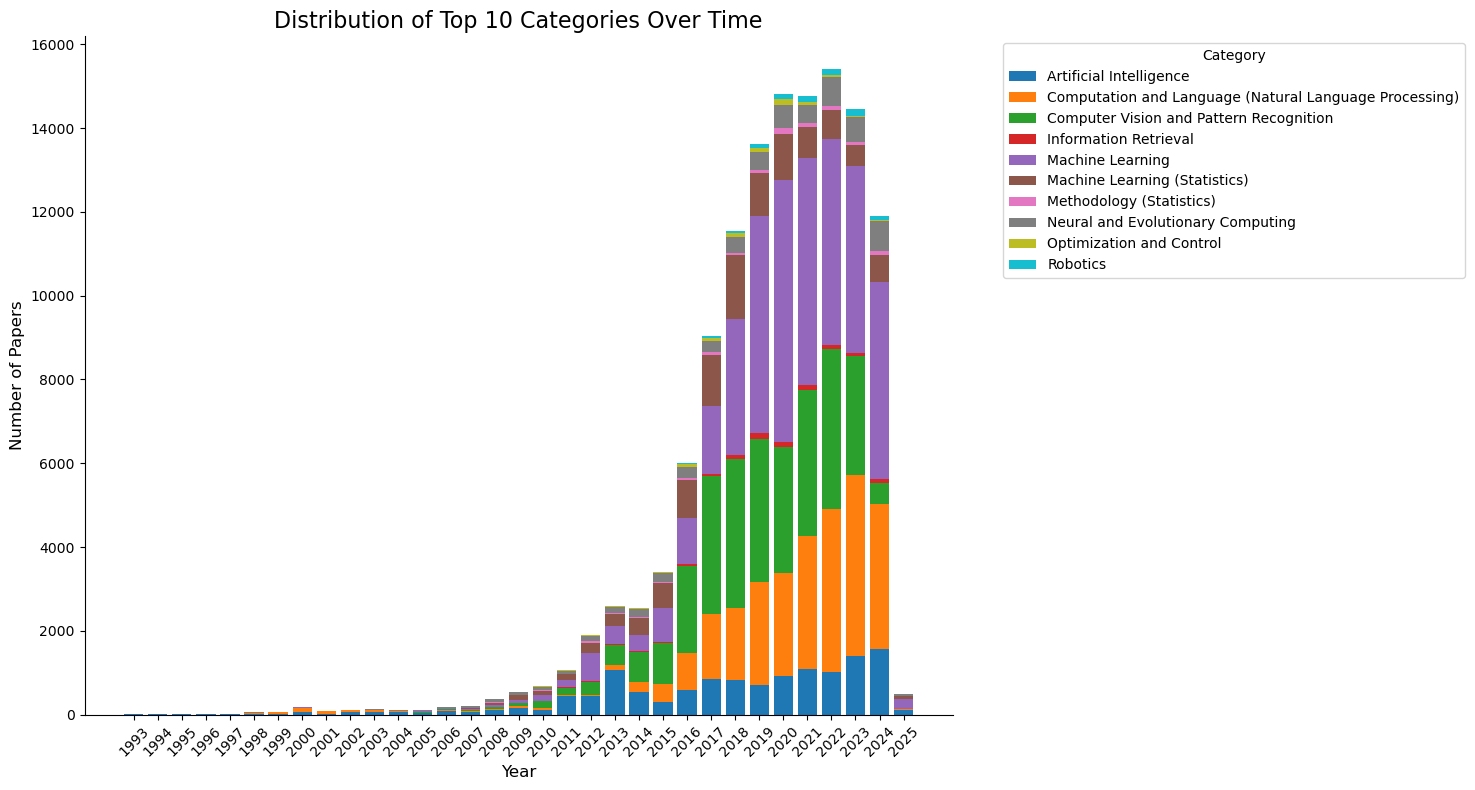

In [59]:
# Get the top 10 categories by frequency
top10_categories = df['category'].value_counts().head(10).index.tolist()

# Create a dataframe with counts of top 10 categories by year
yearly_category_counts = df[df['category'].isin(top10_categories)].groupby(['published_year', 'category']).size().unstack()

# Fill missing values with 0
yearly_category_counts = yearly_category_counts.fillna(0)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(15, 8))
bottom = np.zeros(len(yearly_category_counts))

# Assign a distinct color to each category
colors = plt.cm.tab10(np.linspace(0, 1, len(top10_categories)))

# Plot each category as a stacked bar
for i, category in enumerate(yearly_category_counts.columns):
    ax.bar(yearly_category_counts.index, yearly_category_counts[category], 
           bottom=bottom, label=category, color=colors[i])
    bottom += yearly_category_counts[category].values

# Add labels and legend
ax.set_title('Distribution of Top 10 Categories Over Time', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine(top=True, right=True)
# Ensure x-axis shows all years
ax.set_xticks(yearly_category_counts.index)
ax.set_xticklabels(yearly_category_counts.index, rotation=45)

plt.tight_layout()
plt.show()

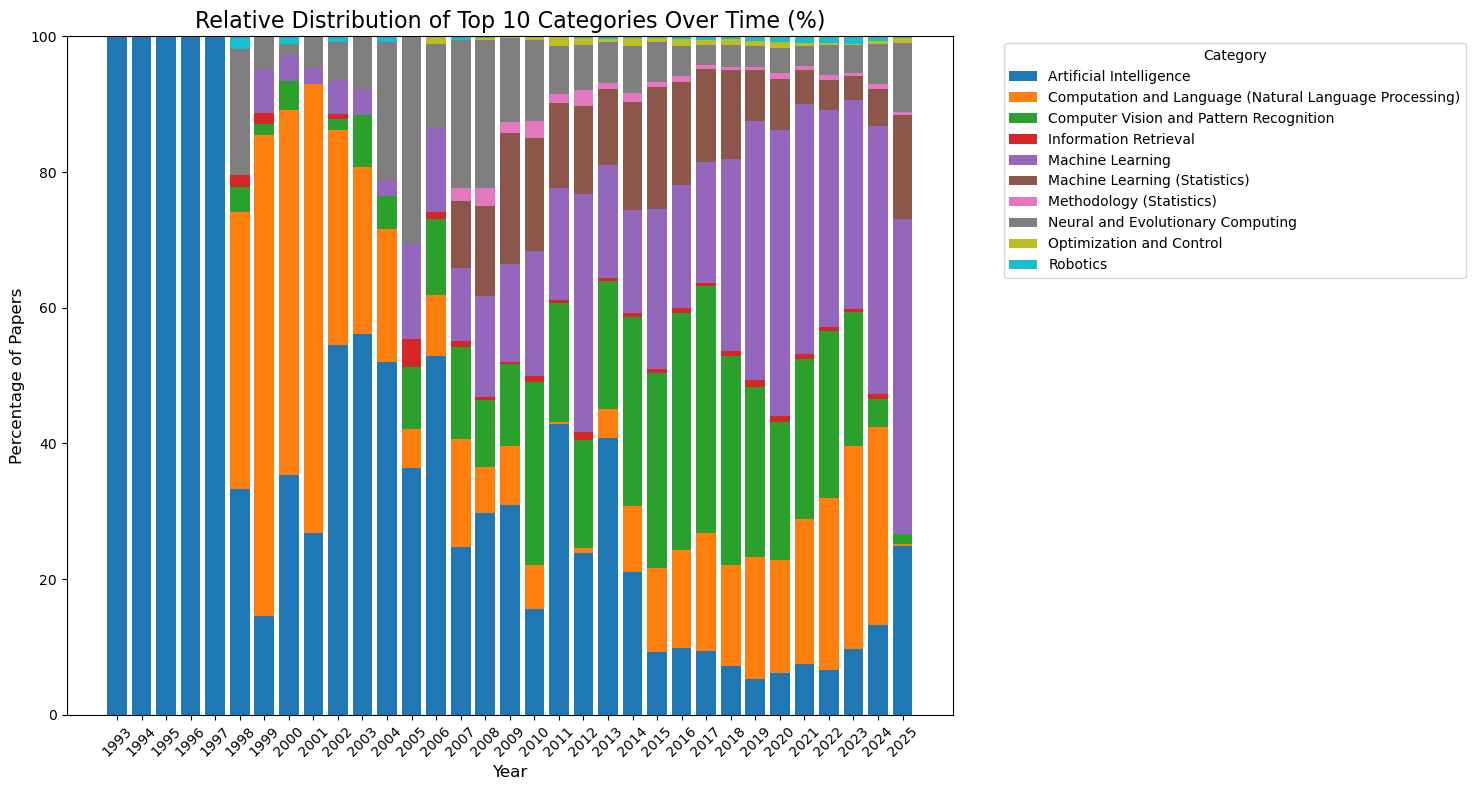

In [60]:
# Create a percentage stacked bar chart to see relative proportions
plt.figure(figsize=(15, 8))
yearly_percent = yearly_category_counts.div(yearly_category_counts.sum(axis=1), axis=0) * 100

# Plot the percentage stacked bar chart
bottom = np.zeros(len(yearly_percent))
for i, category in enumerate(yearly_percent.columns):
    plt.bar(yearly_percent.index, yearly_percent[category], 
            bottom=bottom, label=category, color=colors[i])
    bottom += yearly_percent[category].values

plt.title('Relative Distribution of Top 10 Categories Over Time (%)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of Papers', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(yearly_percent.index, rotation=45)
plt.tight_layout()
plt.show()

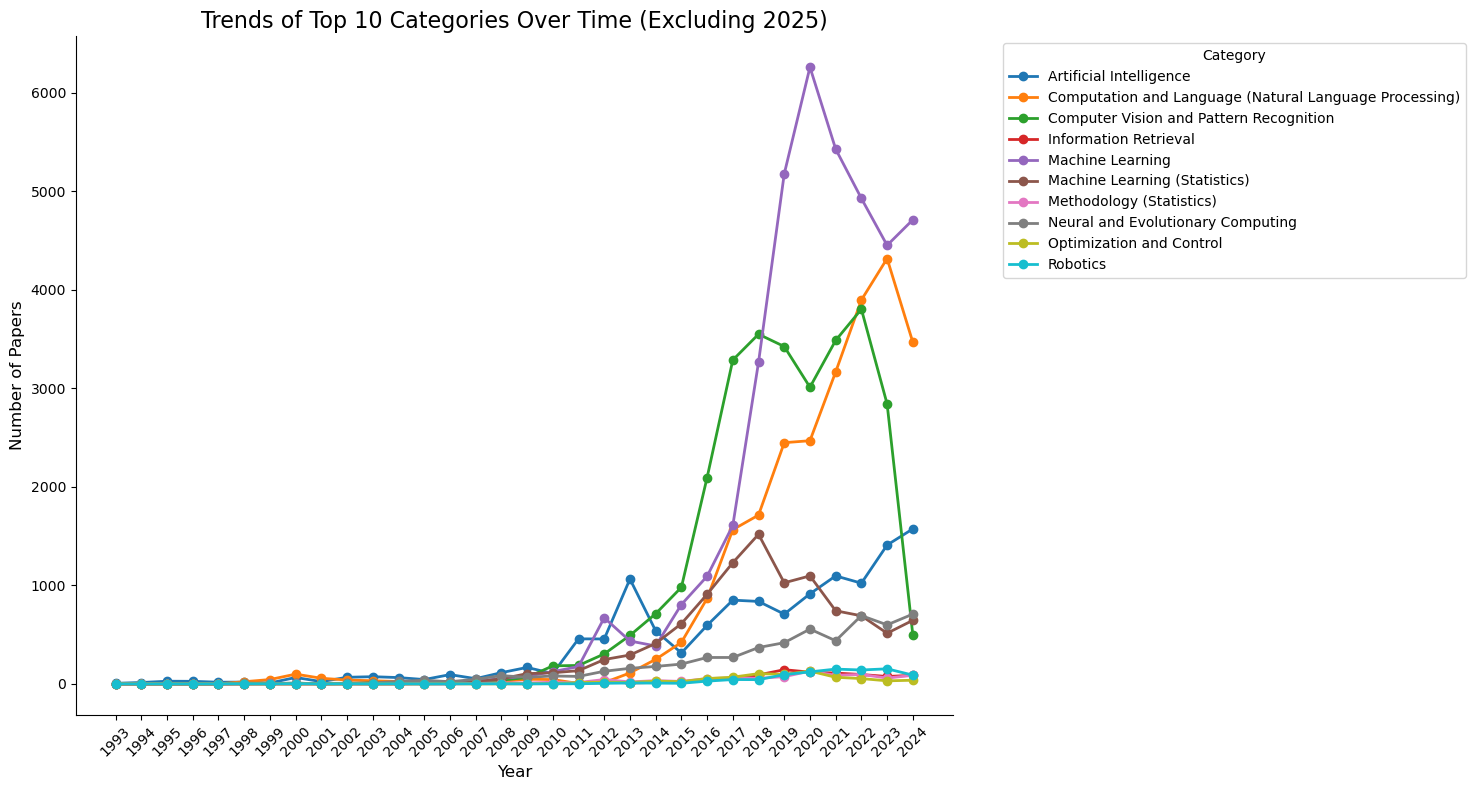

In [63]:
# Add a line chart to visualize trends for each category
# Filter out 2025 for the line chart
yearly_category_counts_filtered = yearly_category_counts[yearly_category_counts.index < 2025]
# Assign a distinct color to each category
colors = plt.cm.tab10(np.linspace(0, 1, len(top10_categories)))

# Create a line chart for trends excluding 2025
plt.figure(figsize=(15, 8))
for i, category in enumerate(yearly_category_counts_filtered.columns):
    plt.plot(yearly_category_counts_filtered.index, yearly_category_counts_filtered[category], 
             marker='o', label=category, color=colors[i], linewidth=2)

plt.title('Trends of Top 10 Categories Over Time (Excluding 2025)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine(top=True, right=True)
plt.xticks(yearly_category_counts_filtered.index, rotation=45)
plt.tight_layout()
plt.show()

There are some clear trends over time- in particular the move to more granular descriptions of the papers.

# Look for relationships between features

In [69]:
# Calculate ANOVA for each numerical column against category_code
num_columns = ['summary_word_count', 'author_count', 'title_count']
print("ANOVA Results (Do numerical features vary across categories?):")
for col in num_columns:
    f_val, p_val = anova_analysis(df, col, 'category_code')
    print(f"{col}: F-value={f_val:.2f}, p-value={p_val:.4f}, Significant={p_val < 0.05}")

ANOVA Results (Do numerical features vary across categories?):
summary_word_count: F-value=36.52, p-value=0.0000, Significant=True
author_count: F-value=13.38, p-value=0.0000, Significant=True
title_count: F-value=21.80, p-value=0.0000, Significant=True


In [70]:
# Group years into periods to reduce sparsity
df['year_period'] = pd.cut(df['published_year'], bins=[1990, 2000, 2010, 2020, 2025], 
                          labels=['1990s', '2000s', '2010s', '2020s'])

# Use only top categories to avoid sparse cells
top_cats = df['category_code'].value_counts().head(5).index
filtered_df = df[df['category_code'].isin(top_cats)]
chi2, p_val, contingency = chi_square_test(filtered_df, 'year_period', 'category_code')
print(f"\nChi-Square Test (Year Period vs Category):")
print(f"Chi2={chi2:.2f}, p-value={p_val:.4f}, Significant={p_val < 0.05}")


Chi-Square Test (Year Period vs Category):
Chi2=7316.41, p-value=0.0000, Significant=True


In [77]:
# Calculate mutual information for available features

# Calculate mutual information with simplified approach
feature_list = ['summary_word_count', 'author_count', 'title_count', 'published_year', 'updated_year']
mi_scores = calculate_mutual_info_simple(df, 'category_code', feature_list)
print("\nMutual Information Scores (Higher = Stronger Relationship):")
print(mi_scores.sort_values(ascending=False))


Mutual Information Scores (Higher = Stronger Relationship):
published_year        0.128019
updated_year          0.117317
author_count          0.036200
summary_word_count    0.026633
title_count           0.014710
dtype: float64


# Conclusions
The count variables provide information as they vary across categories. however, they are not correlated with each other, and they seem to provide independent information. They should all be retained as part of the model development. 

In [78]:
display(df.head())

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count,...,title_count,author_count_boxcox,title_count_sqrt,published_year,published_quarter,published_month,updated_year,updated_quarter,updated_month,year_period
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,1993-08-01,1993-08-01,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79,...,2,0.000000,1.414214,1993,1993Q3,1993-08,1993,1993Q3,1993-08,1990s
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,1993-08-01,1993-08-01,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119,...,12,0.000000,3.464102,1993,1993Q3,1993-08,1993,1993Q3,1993-08,1990s
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,1993-09-01,1993-09-01,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167,...,7,0.715010,2.645751,1993,1993Q3,1993-09,1993,1993Q3,1993-09,1990s
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,1993-11-01,1993-11-01,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174,...,8,1.154208,2.828427,1993,1993Q4,1993-11,1993,1993Q4,1993-11,1990s
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,1993-11-01,1993-11-01,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187,...,8,0.715010,2.828427,1993,1993Q4,1993-11,1993,1993Q4,1993-11,1990s


In [79]:
df.to_csv('../data/processed/arXiv_scientific_dataset_final.csv', index=False)


In [80]:
!conda list

# packages in environment at /Users/deannachurch/opt/anaconda3/envs/arxiv-analysis:
#
# Name                    Version                   Build  Channel
aiohappyeyeballs          2.6.1              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.16         py310hc74094e_0    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0              pyhd8ed1ab_1    conda-forge
anyio                     4.9.0              pyh29332c3_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_1    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_1    conda-forge
argon2-cffi-bindings      21.2.0          py310h493c2e1_5    conda-forge
arrow                     1.3.0              pyhd8ed1ab_1    conda-forge
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
async-lru                 2.0.5              pyh29332c3_0    conda-forge
async-timeout             5.0.1             